In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import time

import cv2
import imageio
import imgaug as ia
import imgaug.augmenters as iaa

from PIL import Image

import tensorflow as tf
import keras
from keras import models, layers
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.utils import plot_model

from tensorflow.keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint

# Data Augmentation and Pre-Processing

In [2]:
def augment(image_folder, image_file):
    
    '''
    Create synthetic images using data augmentation techniques.

    Parameters
    ----------
    image_folder : string
        Path of the folder containing the original image.
        
    image_file : string
        Filename of the original image.
        
    Returns
    -------
    None.

    '''
    
    path = image_folder + "/" + image_file
    origin_img = imageio.imread(path)
    
    aug_img = {}
    
    aug_img['flipped'] = iaa.Flipud(p=1.0).augment_image(origin_img)
    aug_img['rotated_1'] = iaa.Affine(rotate=(-50, 50)).augment_image(origin_img)
    aug_img['rotated_2'] = iaa.Affine(rotate=(-50, 50)).augment_image(origin_img)
    aug_img['cropped_1'] = iaa.Crop(percent=(0, 0.3)).augment_image(origin_img)
    aug_img['cropped_2'] = iaa.Crop(percent=(0, 0.3)).augment_image(origin_img)
    aug_img['constrated_1'] = iaa.GammaContrast(gamma=2.0).augment_image(origin_img)
    aug_img['constrated_2'] = iaa.GammaContrast(gamma=2.0).augment_image(origin_img)
    aug_img['constrated_3'] = iaa.AllChannelsCLAHE(clip_limit=(1, 10)).augment_image(origin_img)

    for key in aug_img.keys():
        save_path = path.split(".")[0] + f'_{key}.jpg'
        cv2.imwrite(save_path, aug_img[key])

In [3]:
dir_path = 'C:/Users/s1027177/OneDrive - Syngenta/Documents/ML-DL/project/Palm-Recognition/images/'
out_path = 'C:/Users/s1027177/OneDrive - Syngenta/Documents/ML-DL/project/Palm-Recognition/processed_images/'
model_path = 'C:/Users/s1027177/OneDrive - Syngenta/Documents/ML-DL/project/Palm-Recognition/model/'

In [5]:
def preprocess(image_folder, image_file, dim):
    
    '''
    Pre-process an image to convert it into a numpy array.

    Parameters
    ----------
    image_folder : string
        Path of the folder containing the image to be processed.
        
    image_file : string
        Filename of the image to be processed.
        
    dim : integer
        Image dimension size. Large enough to capture the details of the palm.
        
    Returns
    -------
    numpy.array of an image normalized to a scale of [0,1] as the pixel values range from 0-255.

    '''
     
    path = image_folder + "/" + image_file
    resize_image = Image.open(path).resize((dim, dim))
    resize_image = np.asarray(resize_image)
    image = resize_image / 255
        
    return(image)

In [6]:
# Load images
# Get synthetic images once
# Pre-process images to convert them into numpy arrays

dim = 224
list_img_folders = os.listdir(dir_path)

images = []
for i in range(len(list_img_folders)):
    
    image_folder = os.path.join(dir_path, list_img_folders[i])
    
    image_names = os.listdir(image_folder)  
    augment(image_folder, image_names[0])  
    image_names = os.listdir(image_folder)
    
    sub_images = []
    for image_file in image_names:
        
        try:
            print(image_folder + "/" + image_file)
            image = preprocess(image_folder, image_file, dim)
            sub_images.append(image)
            images.append(image)
        except:
            print(f'Cannot process the file: {image_folder + "/" + image_file}')
            
    sub_images = np.array(sub_images)
    np.save( f'{image_folder}/{list_img_folders[i]}_processed.npy', sub_images)
    
    print("Save Complete")

C:/Users/s1027177/OneDrive - Syngenta/Documents/ML-DL/project/Palm-Recognition/images/p1/jacques.jpg
C:/Users/s1027177/OneDrive - Syngenta/Documents/ML-DL/project/Palm-Recognition/images/p1/jacques_constrated_1.jpg
C:/Users/s1027177/OneDrive - Syngenta/Documents/ML-DL/project/Palm-Recognition/images/p1/jacques_constrated_2.jpg
C:/Users/s1027177/OneDrive - Syngenta/Documents/ML-DL/project/Palm-Recognition/images/p1/jacques_constrated_3.jpg
C:/Users/s1027177/OneDrive - Syngenta/Documents/ML-DL/project/Palm-Recognition/images/p1/jacques_cropped_1.jpg
C:/Users/s1027177/OneDrive - Syngenta/Documents/ML-DL/project/Palm-Recognition/images/p1/jacques_cropped_2.jpg
C:/Users/s1027177/OneDrive - Syngenta/Documents/ML-DL/project/Palm-Recognition/images/p1/jacques_flipped.jpg
C:/Users/s1027177/OneDrive - Syngenta/Documents/ML-DL/project/Palm-Recognition/images/p1/jacques_rotated_1.jpg
C:/Users/s1027177/OneDrive - Syngenta/Documents/ML-DL/project/Palm-Recognition/images/p1/jacques_rotated_2.jpg
Save

In [7]:
images = np.array(images)

In [8]:
# Create pairs of images to be fed as input to the Siamese Network
samples_1 = []
samples_2 = []
labels = []

for i in range(len(images)):
    for j in range(len(images)):
        samples_1.append(images[i])
        samples_2.append(images[j])
        t = i - i%9 +9
        if t - 9 <= j < t:
            labels.append(1)
        else:
            labels.append(0)

X1 = np.array(samples_1)
X2 = np.array(samples_2)
Y = np.array(labels)

print(X1.shape)
print(X2.shape)
print(Y.shape)

(729, 224, 224, 3)
(729, 224, 224, 3)
(729,)


# Siamese network implementation using Keras

### References
To create the model architecture specific to Siamese Network we found two complementary posts
[One Shot Learning with Siamese Networks using Keras](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) and a line by line explanation of how Siamese Networks are implemented using Keras in Python 
[Siamese Networks](https://towardsdatascience.com/siamese-networks-line-by-line-explanation-for-beginners-55b8be1d2fc6).

![siamese_network](siamese_network.png)

As it is a similar use case as the one of a fingerprint-recognition system, the parameters are essentially chosen as described in [Fingerprint Recognition using Siamese Network](https://github.com/utsav-195/fingerprint-recognition-using-siamese-network-with-retraining).

In [10]:
def get_siamese_model(input_shape, convolution_shape):
    
    '''
        Model architecture
    '''
    
    # Define the tensors for the two input images 
    input_x1 = Input(input_shape)
    input_x2 = Input(input_shape)
    
    model = models.Sequential([
        layers.Reshape(input_shape=input_shape, target_shape=convolution_shape),
        layers.Conv2D(64, (10,10), strides=1, activation='relu'),
        layers.MaxPooling2D(strides=2),
        layers.Conv2D(128, (7,7), strides=1, activation='relu'),
        layers.MaxPooling2D(strides=2),
        layers.Conv2D(128, (4,4), strides=1, activation='relu'),
        layers.MaxPooling2D(strides=2),
        layers.Conv2D(256, (4,4), strides=1, activation='relu'),
        layers.MaxPooling2D(strides=2),
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dense(1024, activation='sigmoid')
    ])
    
    # Generate the encodings (feature vectors) for the two images
    output_x1 = model(input_x1)
    output_x2 = model(input_x2)
    
    # Add a customized layer to compute the absolute difference between the encodings
    distance_euclid = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))([output_x1, output_x2])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    outputs = layers.Dense(1, activation='sigmoid')(distance_euclid)
    
    # Connect the inputs with the outputs
    siamese_net = Model([input_x1, input_x2], outputs)
    
    # Return the model
    return siamese_net

In [16]:
def save_model(model, file_path):
    model.save(file_path)

def load_model(file_path):
    model = models.load_model(file_path)
    return(model)

In [11]:
# Compile the model with loss as Binary Cross-Entropy loss and Adam optimizer
dim = 224
input_shape = ((dim**2)*3, )
convolution_shape = (dim, dim, 3)

model = get_siamese_model(input_shape, convolution_shape)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr = 0.00003))

# Give the model parameters
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150528)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 150528)]     0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         28472640    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1024)         0           sequential[0][0]      

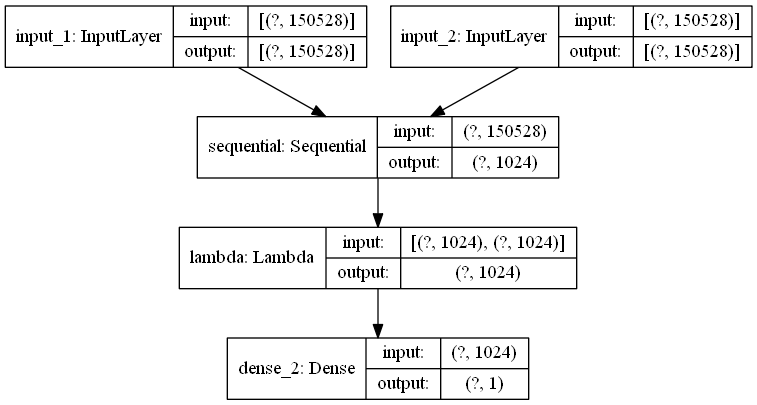

In [12]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Training the Model

In [ ]:
def load_train_arrays(dim, out_path):
    
    '''
    Load the saved numpy arrays if not created from previous execution.
    
    Parameters
    ----------
    dim : integer
        Input size.
        
    out_path : string
        Path where numpy arrays have been saved.
        
    Returns
    -------
    X1, X2: numpy.array
        Training image pairs.
        
    Y: numpy.array
        Training labels where 1 indicates a pair of images belonging to the same person, 0 otherwise.
    
    '''
    
    X1 = np.load(f'{out_path}/x1.npy')
    X2 = np.load(f'{out_path}/x2.npy')
    Y = np.load(f'{out_path}/y.npy')

    return(X1, X2, Y)

In [13]:
# checkpointer to save the best model
checkpointer = ModelCheckpoint(filepath= f'{model_path}/test3_model.h5', monitor='loss', verbose=1, save_best_only=True)

# Reshape inputs to the required format
X1 = X1.reshape((X1.shape[0], dim**2 * 3)).astype(np.float32)
X2 = X2.reshape((X2.shape[0], dim**2 * 3)).astype(np.float32)

model.fit(
    [ X1 , X2 ],
    Y,
    batch_size = 64,
    epochs = 20,
    callbacks = checkpointer,
    validation_data = None
    )

Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 0.6859 
Epoch 00001: loss improved from inf to 0.68586, saving model to C:/Users/s1027177/OneDrive - Syngenta/Documents/ML-DL/project/Palm-Recognition/model\test3_model.h5
12/12 [==============================] - 301s 25s/step - loss: 0.6859
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 0.6394 
Epoch 00002: loss improved from 0.68586 to 0.63937, saving model to C:/Users/s1027177/OneDrive - Syngenta/Documents/ML-DL/project/Palm-Recognition/model\test3_model.h5
12/12 [==============================] - 313s 26s/step - loss: 0.6394
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 0.5910 
Epoch 00003: loss improved from 0.63937 to 0.59100, saving model to C:/Users/s1027177/OneDrive - Syngenta/Documents/ML-DL/project/Palm-Recognition/model\test3_model.h5
12/12 [==============================] - 330s 27s/step - loss: 0.5910
Epoch 4/20
12/12 [==============================] - ETA: 0s - 

## Validating the Model

In [46]:
dir_test_path = 'C:/Users/s1027177/OneDrive - Syngenta/Documents/ML-DL/project/Palm-Recognition/test_images'

In [47]:
# Prepare test images and convert them into numpy arrays
# Reshape them to the required format

dim = 224
list_test_img = os.listdir(dir_test_path)

test_images = []
for image_file in list_test_img:
    test_image = preprocess(dir_test_path, image_file, dim)
    test_images.append(test_image)

test_images = np.array(test_images)
test_images = test_images.reshape(test_images.shape[0], dim**2 * 3).astype(np.float32)
print(test_images.shape)

(3, 150528)


In [48]:
# Load class numpy arrays
# Reshape them to the required format

samples = {}

list_img_folders = os.listdir(dir_path)

images = []
for i in range(len(list_img_folders)):
    class_name = list_img_folders[i]
    image_names = os.listdir(dir_path + class_name + "/") 
    f = [name for name in image_names if '.npy' in name]
    class_images = np.load('{}{}/{}'.format(dir_path, class_name, f[0]))
    class_images = np.array(class_images)
    samples[class_name] = class_images.reshape((class_images.shape[0], dim**2 * 3)).astype(np.float32)

In [ ]:
# model = load_model('{}/best_model.h5'.format(model_path))

In [50]:
# setting a threshold of 0.9 for prediction confidence
i = 0
threshold = 0.5

for image in test_images:
    image = image.reshape((1, -1))
    for class_name in os.listdir(dir_path):
        for sample in samples[class_name][:2]:
            sample = sample.reshape((1 ,-1))
            prediction_score = model.predict([image, sample])[0]
            if prediction_score > threshold:
                print( 'IMAGE {} is {} with confidence of {}'.format(list_test_img[i], class_name, prediction_score[0]))
                break
        if prediction_score > threshold:
            break
    i += 1

IMAGE p1.jpg is p1 with confidence of 0.7141196727752686
IMAGE p2.jpg is p2 with confidence of 0.5824065208435059
IMAGE p3.jpg is p3 with confidence of 0.9668285846710205
